In [ ]:
from skimage.metrics import structural_similarity as ssim


SSIM function is available ✅


In [6]:
# %matplotlib inline
import argparse
import os
import random
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from torchvision import datasets

from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F


In [7]:

# =========================
# 1. Reproducibility & Hyperparams
# =========================

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)  # Needed for reproducible results

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


Random Seed:  999


Compose(
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Files already downloaded and verified
Train size: 50000
Validation size: 10000
Shape of batch of images after transformation: torch.Size([32, 3, 64, 64])
Device: cpu


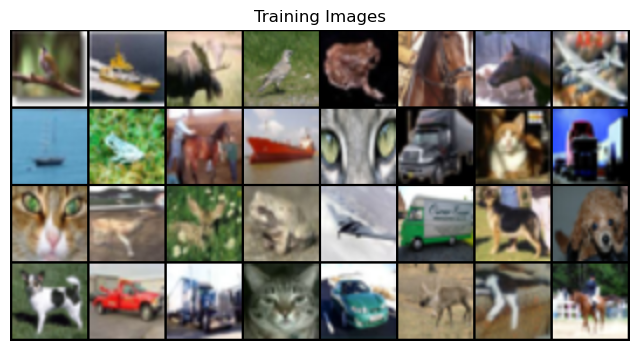

In [ ]:

# =========================
# 2. Data & Dataloaders
# =========================

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

print(transform)

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=workers)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False, num_workers=workers)

print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")

# print the shape of images after transformation
for images, labels in train_loader:
    print(f"Shape of batch of images after transformation: {images.shape}")
    break

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Device:", device)

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [9]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


CUDA Available: False
Device: CPU


In [ ]:
# =========================
# 3. Weights init function
# =========================

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)



### 4. Generator



In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### 5. Discriminator


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)




Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### 6. Loss, labels, optimizers


In [ ]:

criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


### 7. Metric Functions (MSE, SSIM, evaluation)

In [ ]:
def compute_mse(x, recon_x):
    """
    Compute mean MSE between real (x) and reconstructed/generated (recon_x) images.
    Input tensors are in [-1, 1], so rescale to [0, 1] first.
    """
    x = (x + 1) / 2
    recon_x = (recon_x + 1) / 2
    mse_loss = F.mse_loss(x, recon_x, reduction='mean')
    return mse_loss.item()

def compute_ssim(x, recon_x):
    """
    Compute mean SSIM between real (x) and generated (recon_x) images.
    """
    x = (x + 1) / 2
    recon_x = (recon_x + 1) / 2

    # Permute to (batch, height, width, channels)
    x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
    recon_x = recon_x.permute(0, 2, 3, 1).detach().cpu().numpy()

    scores = []
    for i in range(x.shape[0]):
        score = ssim(x[i], recon_x[i], win_size=11, channel_axis=-1, data_range=1.0)
        scores.append(score)

    return float(np.mean(scores))

def evaluate_mse_ssim(netG, data_loader, nz, device):
    """
    Evaluate MSE and SSIM over a dataloader using the generator.
    """
    netG.eval()
    mse_values = []
    ssim_values = []

    with torch.no_grad():
        for real_imgs, _ in data_loader:
            real_imgs = real_imgs.to(device)
            b_size = real_imgs.size(0)

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_imgs = netG(noise)

            mse_values.append(compute_mse(real_imgs, fake_imgs))
            ssim_values.append(compute_ssim(real_imgs, fake_imgs))

    netG.train()
    return np.mean(mse_values), np.mean(ssim_values)

def evaluate_gan(netD, netG, data_loader, criterion, nz, device):
    """
    Compute average D and G loss on a given dataloader (used as 'test error').
    """
    netD.eval()
    netG.eval()
    d_loss = 0.0
    g_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for images, _ in data_loader:
            num_batches += 1
            real_cpu = images.to(device)
            b_size = real_cpu.size(0)

            # D loss: real
            label_real = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            output_real = netD(real_cpu).view(-1)
            errD_real = criterion(output_real, label_real)

            # D loss: fake
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label_fake = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
            output_fake = netD(fake).view(-1)
            errD_fake = criterion(output_fake, label_fake)

            errD = errD_real + errD_fake
            d_loss += errD.item()

            # G loss
            label_for_g = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            output_for_g = netD(fake).view(-1)
            errG = criterion(output_for_g, label_for_g)
            g_loss += errG.item()

    d_loss /= num_batches
    g_loss /= num_batches

    netD.train()
    netG.train()
    return d_loss, g_loss



### 8. Training Loop + tracking losses, errors, time


In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
Epoch_G_losses = []
Epoch_D_losses = []

# New lists for your requested plots
train_errors = []   # total train error (G + D) per epoch
test_errors = []    # total test error (G + D) per epoch
train_times = []    # cumulative training time (seconds)
epochs_list = []    # epoch numbers

iters = 0

print("Starting Training Loop...")
start_time = time.time()

# For each epoch
for epoch in range(num_epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    num_batches = 0

    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):
        num_batches += 1

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        epoch_g_loss += errG.item()
        epoch_d_loss += errD.item()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch + 1, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(train_loader) - 1)):
            with torch.no_grad():
                fake_fixed = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_fixed, padding=2, normalize=True))

        iters += 1

    # End of epoch: average losses
    epoch_g_loss /= num_batches
    epoch_d_loss /= num_batches
    Epoch_G_losses.append(epoch_g_loss)
    Epoch_D_losses.append(epoch_d_loss)

    # Total training error for this epoch
    train_error_epoch = epoch_g_loss + epoch_d_loss
    train_errors.append(train_error_epoch)

    # Validation / test error
    val_d_loss, val_g_loss = evaluate_gan(netD, netG, val_loader, criterion, nz, device)
    test_error_epoch = val_d_loss + val_g_loss
    test_errors.append(test_error_epoch)

    # Time since start of training
    elapsed_time = time.time() - start_time
    train_times.append(elapsed_time)
    epochs_list.append(epoch + 1)

    print(f"Epoch {epoch + 1}/{num_epochs} "
          f"- G Loss: {epoch_g_loss:.4f}, D Loss: {epoch_d_loss:.4f}, "
          f"Train error: {train_error_epoch:.4f}, Test error: {test_error_epoch:.4f}")



Starting Training Loop...
[1/50][0/1563]	Loss_D: 1.8575	Loss_G: 6.9629	D(x): 0.6457	D(G(z)): 0.6576 / 0.0014
[1/50][50/1563]	Loss_D: 1.9086	Loss_G: 22.6522	D(x): 0.9941	D(G(z)): 0.8140 / 0.0000
[1/50][100/1563]	Loss_D: 0.1404	Loss_G: 5.7305	D(x): 0.9156	D(G(z)): 0.0331 / 0.0066
[1/50][150/1563]	Loss_D: 0.3506	Loss_G: 5.8317	D(x): 0.7796	D(G(z)): 0.0080 / 0.0044
[1/50][200/1563]	Loss_D: 0.2395	Loss_G: 6.1078	D(x): 0.9750	D(G(z)): 0.1739 / 0.0030
[1/50][250/1563]	Loss_D: 0.6310	Loss_G: 5.7452	D(x): 0.8190	D(G(z)): 0.2259 / 0.0068
[1/50][300/1563]	Loss_D: 0.7512	Loss_G: 6.7198	D(x): 0.9121	D(G(z)): 0.4052 / 0.0043
[1/50][350/1563]	Loss_D: 0.5214	Loss_G: 4.3436	D(x): 0.8416	D(G(z)): 0.2389 / 0.0187
[1/50][400/1563]	Loss_D: 0.3361	Loss_G: 6.2103	D(x): 0.9372	D(G(z)): 0.2051 / 0.0030
[1/50][450/1563]	Loss_D: 0.2530	Loss_G: 4.8489	D(x): 0.8755	D(G(z)): 0.0334 / 0.0186
[1/50][500/1563]	Loss_D: 0.5718	Loss_G: 3.0892	D(x): 0.7036	D(G(z)): 0.0235 / 0.0724
[1/50][550/1563]	Loss_D: 0.4844	Loss_G: 6

### 9. MSE & SSIM on train and test


In [ ]:
train_mse, train_ssim = evaluate_mse_ssim(netG, train_loader, nz, device)
test_mse, test_ssim = evaluate_mse_ssim(netG, val_loader, nz, device)

print("\n=== MSE and SSIM ===")
print(f"Train MSE : {train_mse:.6f}, Train SSIM : {train_ssim:.4f}")
print(f"Test  MSE : {test_mse:.6f}, Test  SSIM : {test_ssim:.4f}")


=== MSE and SSIM ===
Train MSE : 0.068412, Train SSIM : 0.0846
Test  MSE : 0.067908, Test  SSIM : 0.0845


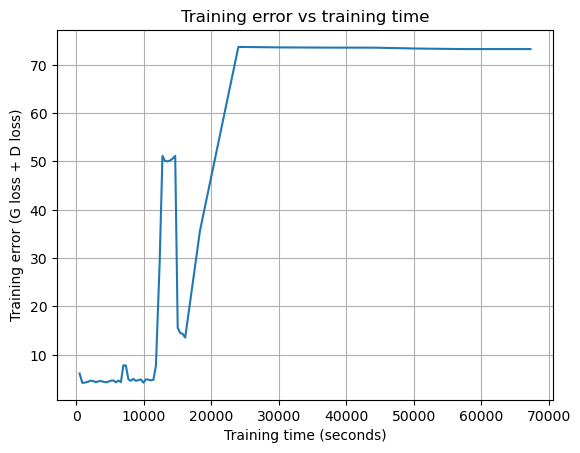

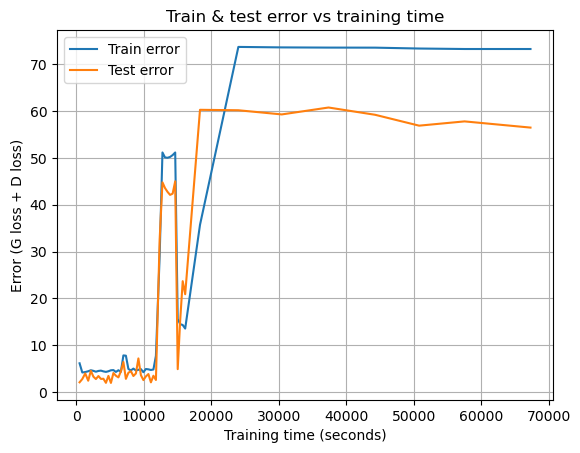

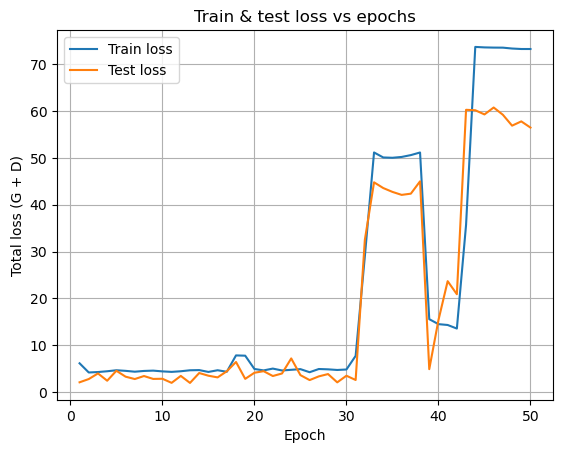

In [17]:
# =========================
# 10. Plots you requested
# =========================

# 1) Training error vs training time
plt.figure()
plt.plot(train_times, train_errors)
plt.xlabel("Training time (seconds)")
plt.ylabel("Training error (G loss + D loss)")
plt.title("Training error vs training time")
plt.grid(True)
plt.show()

# 2) Train & test error vs training time
plt.figure()
plt.plot(train_times, train_errors, label="Train error")
plt.plot(train_times, test_errors, label="Test error")
plt.xlabel("Training time (seconds)")
plt.ylabel("Error (G loss + D loss)")
plt.title("Train & test error vs training time")
plt.legend()
plt.grid(True)
plt.show()

# 3) Train & test loss vs number of epochs
plt.figure()
plt.plot(epochs_list, train_errors, label="Train loss")
plt.plot(epochs_list, test_errors, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Total loss (G + D)")
plt.title("Train & test loss vs epochs")
plt.legend()
plt.grid(True)
plt.show()
